## 1 Implementation

You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state *s* (dealer\`s first card 1-10 and the player\`s sum 1-21), and an action *a* (hit or stick), and returns a sample of the next state *s*' (which may be terminal if the game is finished) and reward *r*. We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discouting (gamma = 1). You should treat the dealer\`s moves as part of the environment, i.e. calling *step* with a *stick* action will play out the dealer\`s cards and return the final reward and terminal state.

__Environment__
- Step Function
    * state s (dealerValue and playerValue)
    * action a (hit or stick)
    * return (next state s' and reward *r* and terminal state)
* no discounting factor (gamma = 1)

In [11]:

class EasyEnv(object):
    def __init__(self):
        self.lowerbound = 1
        self.upperbound = 21
        # 1 is hit and 0 is stick
        self.actions = [0, 1]
    
    def initGame(self):
        self.playerValue = np.random.randint(1, 11)
        self.dealerValue = np.random.randint(1, 11)
        
    def draw(self):
        card_value = np.random.randint(1, 11)
        
        if round(np.random.rand(), 2) <= 0.3:
            return -card_value
        else:
            return card_value
        
    def get_state(self):
        return self.playerValue, self.dealerValue
    
    def step(self, playerValue, dealerValue, action):
        
        # Hit
        if action == 1:
            playerValue += self.draw()
            
            if playerValue > self.upperbound or playerValue < self.lowerbound:
                reward = -1
                terminated = True
            else:
                reward = 0
                terminated = False
        else:
            # Player Action is Stick. Dealer`s turn.
            while dealerValue < 17:
                dealerValue += self.draw()
                
            if dealerValue > self.upperbound or dealerValue < self.lowerbound or playerValue > dealerValue:
                reward = 1
            elif playerValue == dealerValue:
                reward = 0
            else:
                reward = -1
                
            terminated = True
        
        return playerValue, dealerValue, reward, terminated
    

## 2 MonteCarlo

Apply Monte-Carlo control to Easy21. Initialise the value function to zero.
Use a time-varying scalar step-size of alpha_t = 1/N(s_t, a_t) and an epsilon-greedy exploration strategy with epsilon_t = N_0 / (N_0 + N(s_t)), where N_0 = 100 is a constant, N(s) is the number of times that state s has been visited, and N(s, a) is the number of times that action a has been selected from state s. Feel free to choose an alternative value for N_0, if it helps producing better results.
Plot the optimal value function V\*(s) = max_aQ\*(s, a)using similar axes to the following figure taken from Sutton and Barto\`s Blackjack example

__Value Function__
- Initialise : zero

__step-size__
- alpha_t = 1/N(s_t, a_t)

__epsilon-greedy exploration__
- epsilon_t = N_0/(N_0 + N(s_t)), N_0 = 100 is a constant

N(s): number of times that state __s__ has been visited.  
N(s, a): number of times that action __a__ has been selected from state s.

__Optimal value function__  
V\*(s) = max_aQ\*(s, a) 
  
Plot the optimal value function


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [76]:

N_0 = 100
actions = [0, 1] # 0 is Stick, 1 is Hit.
N_s_dict = {} # Number of times that state s has been visited.
N_sa_dict = {} # Number of times that action a has been selected from state s.
Q_sa_dict = {} # Action-State Value
V_s_dict = {} # State Value

   
def calc_epsilon(N_s):
    if N_s not in N_s_dict.keys():
        N_s_dict[N_s] = 0
    epsilon_t = N_0/(N_0 + N_s_dict[N_s])
    return epsilon_t

def calc_alpha(N_sa):
    alpha = 1 / N_sa
    return alpha

def epsilonGreedy(pValue, dValue):
    epsilon = calc_epsilon((pValue, dValue))
    if (pValue, dValue, 0) not in Q_sa_dict.keys():
        Q_sa_dict[(pValue, dValue, 0)] = 0
    if (pValue, dValue, 1) not in Q_sa_dict.keys():
        Q_sa_dict[(pValue, dValue, 1)] = 0
  
    max_action = np.argmax([Q_sa_dict[pValue, dValue, act] for act in actions])
    
    #RandomPolicy
    if epsilon is 1:
        return np.random.choice(actions)
    
    # Exploitation
    if round(np.random.rand(), 2) > epsilon:
        return max_action
    # Explore
    else:
        if max_action:
            return 0
        else:
            return 1

env = EasyEnv()
episodes = 1000000

for episode in range(episodes):
    terminated = False
    H = []

    env.initGame()
    pValue, dValue = env.get_state()
    reward = 0

    while not terminated:

        if (pValue, dValue) not in N_s_dict.keys():
            N_s_dict[(pValue, dValue)] = 0
        N_s_dict[(pValue, dValue)] += 1

        action = epsilonGreedy(pValue, dValue)
        if (pValue, dValue, action) not in N_sa_dict.keys():
            N_sa_dict[(pValue, dValue, action)] = 1
        else:
            N_sa_dict[(pValue, dValue, action)] += 1

        pPrime, dPrime, reward, terminated = env.step(pValue, dValue, action)

        H.append([pValue, dValue, action, reward])

        pValue, dValue = pPrime, dPrime

    G = reward

    for (pValue, dValue, action, _) in H:
        alpha = calc_alpha(N_sa_dict[(pValue, dValue, action)])
        if (pValue, dValue, action) not in Q_sa_dict.keys():
            Q_sa_dict[(pValue, dValue, action)] = 0
        Q_sa_dict[(pValue, dValue, action)] += alpha*(G - Q_sa_dict[(pValue, dValue, action)])

In [57]:
Q_sa_dict

{(1, 1, 0): -0.5295766189570623,
 (1, 1, 1): -0.7013274336283191,
 (1, 2, 0): -0.5355343001131341,
 (1, 2, 1): -0.6975169300225725,
 (1, 3, 0): -0.4981265822784818,
 (1, 3, 1): -0.6758543417366952,
 (1, 4, 0): -0.5080924314716083,
 (1, 4, 1): -0.6831240637246132,
 (1, 5, 0): -0.4844117346417265,
 (1, 5, 1): -0.697241092239624,
 (1, 6, 0): -0.46697228589289463,
 (1, 6, 1): -0.6559829059829059,
 (1, 7, 0): -0.5135537959944115,
 (1, 7, 1): -0.6870660030528768,
 (1, 8, 0): -0.5343639022352235,
 (1, 8, 1): -0.6792672670835128,
 (1, 9, 0): -0.5505617977528084,
 (1, 9, 1): -0.6922092683754087,
 (1, 10, 0): -0.5933247243468759,
 (1, 10, 1): -0.6972588666846699,
 (2, 1, 0): -0.5290420679168796,
 (2, 1, 1): -0.6507561300023134,
 (2, 2, 0): -0.5217347042654968,
 (2, 2, 1): -0.6369863013698631,
 (2, 3, 0): -0.5038363171355493,
 (2, 3, 1): -0.6191580353788727,
 (2, 4, 0): -0.5019719343300013,
 (2, 4, 1): -0.6633515537448763,
 (2, 5, 0): -0.471045631266627,
 (2, 5, 1): -0.6773505683716651,
 (2, 6, 0

In [58]:
for i in range(1, 22):
    for j in range(1, 11):
        if Q_sa_dict[(i, j, 0)] > Q_sa_dict[(i, j, 1)]:
            V_s_dict[(i, j)] = Q_sa_dict[(i, j, 0)]
        else:
            V_s_dict[(i, j)] = Q_sa_dict[(i, j, 1)]

In [59]:
V_s_dict

{(1, 1): -0.5295766189570623,
 (1, 2): -0.5355343001131341,
 (1, 3): -0.4981265822784818,
 (1, 4): -0.5080924314716083,
 (1, 5): -0.4844117346417265,
 (1, 6): -0.46697228589289463,
 (1, 7): -0.5135537959944115,
 (1, 8): -0.5343639022352235,
 (1, 9): -0.5505617977528084,
 (1, 10): -0.5933247243468759,
 (2, 1): -0.5290420679168796,
 (2, 2): -0.5217347042654968,
 (2, 3): -0.5038363171355493,
 (2, 4): -0.5019719343300013,
 (2, 5): -0.471045631266627,
 (2, 6): -0.46114623699775753,
 (2, 7): -0.4890914112123732,
 (2, 8): -0.5430711610486901,
 (2, 9): -0.5670347722916861,
 (2, 10): -0.5961538461538428,
 (3, 1): -0.5078826581520673,
 (3, 2): -0.511380557328228,
 (3, 3): -0.5180220434912087,
 (3, 4): -0.48876043673731456,
 (3, 5): -0.4808561953572504,
 (3, 6): -0.47552593209747923,
 (3, 7): -0.49262808698857463,
 (3, 8): -0.5256031762190774,
 (3, 9): -0.5513314967860455,
 (3, 10): -0.5697023283230223,
 (4, 1): -0.5374826009146947,
 (4, 2): -0.5233923949830791,
 (4, 3): -0.5134262063395901,
 (4,

In [60]:
z = []
for k, v in V_s_dict.items():
    z.append(v)
    
z = np.array(z)

In [61]:
z = z.reshape(21, 10)

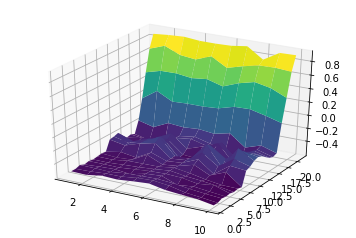

In [62]:
x = np.arange(1, 11)
y = np.arange(1, 22)
xs, ys = np.meshgrid(x, y)
z = np.array(z)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xs, ys, z, rstride=1, cstride=1, cmap='viridis')
plt.show()


## 3 TD Learning

Implement Sarsa(Lamda) in 21s. Initialise the value function to zero. Use the same step-szie and exploration schedules as in the previous section. Run the algorithm with parameter values Lamda = {0, 0.1, 0.2, ..., 1}. Stop each run after 1000 episodes and report the mean-squared error Sigma_s,a(Q(s, a) - Q*(s, a))^square over all states s and actions a, comparing the true values Q*(s, a) computed in the previous section with the estimated values Q(s, a) computed by Sarsa. Plot the mean-squared error against Lamda. For Lamda = 0 and Lamda = 1 only, plot the learning curve of mean-squared error against episode number.

__Value Function__
- Initialise : zero

__step-size__
- alpha_t = 1/N(s_t, a_t)

__epsilon-greedy exploration__
- epsilon_t = N_0/(N_0 + N(s_t)), N_0 = 100 is a constant

N(s): number of times that state __s__ has been visited.  
N(s, a): number of times that action __a__ has been selected from state s.

__Lamda__
- {0, 0.1, 0.2, ..., 1}

__Rule__
- Stop each run after 1000 episodes and report the mean-squared error

__MSE__
- Sigma_s,a(Q(s,a)-Q*(s,a))^square over all states s and actions a
- comparing the true values Q*(s,a) computed in the previous section with estimated values Q(s,a) computed by Sarsa.

__Optimal value function__  
 - V\*(s) = max_aQ\*(s, a) 
 - computed bt 
  
Plot the mean-squared error against Lamda.  
For Lamda = 0 and Lamda = 1 only, plot the learning curve of mean-squared error against episode number.


In [77]:
T_Q = Q_sa_dict

In [78]:
T_Q

{(1, 1, 0): -0.5405629139072848,
 (1, 1, 1): -0.7205542725173205,
 (1, 2, 0): -0.5288744544808665,
 (1, 2, 1): -0.6564145324674007,
 (1, 3, 0): -0.5176757415684673,
 (1, 3, 1): -0.6951833075002148,
 (1, 4, 0): -0.5184748427672923,
 (1, 4, 1): -0.5918671112169558,
 (1, 5, 0): -0.47877474638037837,
 (1, 5, 1): -0.6819116403537568,
 (1, 6, 0): -0.4662809257781331,
 (1, 6, 1): -0.5879717214412756,
 (1, 7, 0): -0.4996427477799331,
 (1, 7, 1): -0.6490795486695529,
 (1, 8, 0): -0.5283223327750928,
 (1, 8, 1): -0.6180761716272112,
 (1, 9, 0): -0.5566561014263092,
 (1, 9, 1): -0.6757322175732215,
 (1, 10, 0): -0.5827699439830037,
 (1, 10, 1): -0.6165254237288131,
 (2, 1, 0): -0.5313510693792369,
 (2, 1, 1): -0.7313299573560762,
 (2, 2, 0): -0.5287275644239451,
 (2, 2, 1): -0.679718464223829,
 (2, 3, 0): -0.5256869772998802,
 (2, 3, 1): -0.7115325244666727,
 (2, 4, 0): -0.5083586626139824,
 (2, 4, 1): -0.6863384050157743,
 (2, 5, 0): -0.496366572466695,
 (2, 5, 1): -0.6460196046428398,
 (2, 6, 0

In [87]:
   
def calc_epsilon(N_s):
    if N_s not in N_s_dict.keys():
        N_s_dict[N_s] = 0
    epsilon_t = N_0/(N_0 + N_s_dict[N_s])
    return epsilon_t

def calc_alpha(N_sa):
    alpha = 1 / N_sa
    return alpha

def epsilonGreedy(pValue, dValue):
    epsilon = calc_epsilon((pValue, dValue))
    if (pValue, dValue, 0) not in Q_sa_dict.keys():
        Q_sa_dict[(pValue, dValue, 0)] = 0
    if (pValue, dValue, 1) not in Q_sa_dict.keys():
        Q_sa_dict[(pValue, dValue, 1)] = 0
  
    max_action = np.argmax([Q_sa_dict[pValue, dValue, act] for act in actions])
    
    #RandomPolicy
    if epsilon is 1:
        return np.random.choice(actions)
    
    # Exploitation
    if round(np.random.rand(), 2) > epsilon:
        return max_action
    # Explore
    else:
        if max_action:
            return 0
        else:
            return 1

env = EasyEnv()
episodes = 10000
lmds = np.arange(0,11)/10
mselamdas = np.zeros((len(lmds), episodes))
finalMSE = np.zeros(len(lmds))
N_0 = 100
actions = [0, 1] # 0 is Stick, 1 is Hit.


for lamC, lmd in enumerate(lmds):

    N_s_dict = {} # Number of times that state s has been visited.
    N_sa_dict = {} # Number of times that action a has been selected from state s.
    Q_sa_dict = {} # Action-State Value
    V_s_dict = {} # State Value
    
    for i in range(1, 22):
        for j in range(1, 11):
            Q_sa_dict[(i, j, 0)] = 0
            Q_sa_dict[(i, j, 1)] = 0
    
    wins = 0

    for episode in range(episodes):

        terminated = False
        E = {}

        env.initGame()
        pValue, dValue = env.get_state()
        action = epsilonGreedy(pValue, dValue)
        SA = []
        reward = 0

        while not terminated:

            pPrime, dPrime, reward, terminated = env.step(pValue, dValue, action)
            
            if not terminated:
                aPrime = epsilonGreedy(pPrime, dPrime)
                tdError = reward + Q_sa_dict[(pPrime, dPrime, aPrime)] - Q_sa_dict[pValue, dValue, action]
            else:
                tdError = reward - Q_sa_dict[(pValue, dValue, action)]
            
            if (pValue, dValue, action) not in E.keys():
                E[(pValue, dValue, action)] = 0
            E[(pValue, dValue, action)] += 1
            
            if (pValue, dValue, action) not in N_sa_dict.keys():
                N_sa_dict[(pValue, dValue, action)] = 1
            else:
                N_sa_dict[(pValue, dValue, action)] += 1
            
            if (pValue, dValue) not in N_s_dict.keys():
                N_s_dict[(pValue, dValue)] = 0
            N_s_dict[(pValue, dValue)] += 1
            
            SA.append([pValue, dValue, action])
            
            alpha = calc_alpha(N_sa_dict[(pValue, dValue, action)])
            for (_p, _d, _a) in SA:
                Q_sa_dict[(_p, _d, _a)] += alpha*tdError*E[_p, _d, _a]
                E[_p, _d, _a] *= lmd
                
            if not terminated:
                pValue, dValue, action = pPrime, dPrime, aPrime

        if reward == 1:
            wins += 1
        
        mse = np.sum(np.square(np.array(list(Q_sa_dict.values())) - np.array(list(T_Q.values())))) / (21*10*2)
        
        mselamdas[lamC, episode] = mse
        
        if (episode + 1) % 1000 == 0:
            print("Lamda=%.1f Episode %06d, MSE %5.3f, Wins %.3f"%(lmd, episode+1, mse, wins/(episode+1)))

    finalMSE[lamC] = mse
    


Lamda=0.0 Episode 001000, MSE 0.223, Wins 0.102
Lamda=0.0 Episode 002000, MSE 0.207, Wins 0.134
Lamda=0.0 Episode 003000, MSE 0.204, Wins 0.149
Lamda=0.0 Episode 004000, MSE 0.193, Wins 0.165
Lamda=0.0 Episode 005000, MSE 0.183, Wins 0.171
Lamda=0.0 Episode 006000, MSE 0.175, Wins 0.175
Lamda=0.0 Episode 007000, MSE 0.162, Wins 0.180
Lamda=0.0 Episode 008000, MSE 0.159, Wins 0.182
Lamda=0.0 Episode 009000, MSE 0.153, Wins 0.184
Lamda=0.0 Episode 010000, MSE 0.153, Wins 0.186
Lamda=0.1 Episode 001000, MSE 0.243, Wins 0.128
Lamda=0.1 Episode 002000, MSE 0.214, Wins 0.161
Lamda=0.1 Episode 003000, MSE 0.193, Wins 0.162
Lamda=0.1 Episode 004000, MSE 0.189, Wins 0.163
Lamda=0.1 Episode 005000, MSE 0.187, Wins 0.171
Lamda=0.1 Episode 006000, MSE 0.191, Wins 0.178
Lamda=0.1 Episode 007000, MSE 0.185, Wins 0.186
Lamda=0.1 Episode 008000, MSE 0.179, Wins 0.189
Lamda=0.1 Episode 009000, MSE 0.176, Wins 0.191
Lamda=0.1 Episode 010000, MSE 0.170, Wins 0.193
Lamda=0.2 Episode 001000, MSE 0.215, Win

In [66]:
mselamdas

array([[0.31849317, 0.31780964, 0.31726052, ..., 0.22510367, 0.22518882,
        0.2251777 ],
       [0.31725547, 0.31646595, 0.3155521 , ..., 0.28088493, 0.28088493,
        0.28088493],
       [0.31798599, 0.3166225 , 0.31535261, ..., 0.26928494, 0.26932182,
        0.26933988],
       ...,
       [0.31936026, 0.31840209, 0.31758379, ..., 0.5677733 , 0.5677733 ,
        0.5677733 ],
       [0.31768519, 0.31732478, 0.31455947, ..., 0.76678602, 0.76479036,
        0.7629348 ],
       [0.31934139, 0.31951607, 0.38038188, ..., 1.12667909, 1.12666432,
        1.12674842]])

In [69]:
mselamdas[10]

array([0.31934139, 0.31951607, 0.38038188, 0.37944342, 0.40181105,
       0.43592583, 0.43708441, 0.43584295, 0.43400465, 0.43265713,
       0.42064775, 0.43298611, 0.43338498, 0.43398303, 0.46556813,
       0.49029475, 0.48942511, 0.48812246, 0.65052345, 0.65652267,
       0.65558585, 0.68226948, 0.68279325, 0.67932897, 0.67682076,
       0.68063215, 0.68179722, 0.68595049, 0.68595049, 0.76072824,
       0.76105677, 0.76183837, 0.84045242, 0.83972421, 0.83978113,
       0.83978113, 0.84192179, 0.83971507, 0.83464621, 0.83464621,
       0.8344398 , 0.84126918, 0.98993162, 0.99514945, 0.9965318 ,
       0.99729544, 0.99741972, 1.00849674, 1.04477389, 1.04407721,
       1.04407721, 1.04403967, 1.04470627, 1.0435735 , 1.04138058,
       1.05784424, 1.08806332, 1.07786711, 1.07786711, 1.07994632,
       1.07741472, 1.08305123, 1.09016302, 1.07967726, 1.09207114,
       1.09149465, 1.09627059, 1.09120389, 1.0907081 , 1.09313138,
       1.08951123, 1.08946973, 1.08842161, 1.09148941, 1.09055

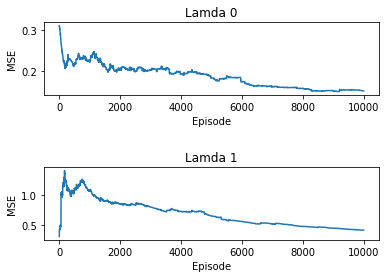

In [88]:
x = np.arange(0,10000)

fig = plt.figure()

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
fig.subplots_adjust(hspace=1, wspace=0.4)

ax1.plot(x, mselamdas[0])
ax1.set_xlabel('Episode')
ax1.set_ylabel('MSE')
ax1.set_title('Lamda 0')
ax2.plot(x, mselamdas[10])
ax2.set_xlabel('Episode')
ax2.set_ylabel('MSE')
ax2.set_title('Lamda 1')

plt.show()

## 4 Linear Function Approximation

We now Consider a simple value function approximator using coarse coding. use a binary vector pi(s, a) with 3\*6\*2 = 36 features. Each binary feature has a value of 1 iff (s,a) lies within the cuboid of state-space corresponding to that feature, and the action corresponding to that feature. The cuboids have the following overlapping intervals:  
  
    dealer(s) = {[1,4],[4,7],[7,10]}  
    player(s) = {[1,6],[4,9],[7,12],[10,15],[13,18],[16,21]}  
    a = {hit, stick}  
  
where 
* dealer(s) is the value of the dealer's first card (1-10)
* sum(s) is the sum of the player's cards (1-21)

Repeat the Sarsa(Lamda) experiment from the previous section, but using linear value function approximation Q(s,a) = pi(s,a)^Ttheta. User a constant exploration of epsilon = 0.05 and a constant step-size of 0.01. Plot the mean-square error against Lamda. For Lamda = 0 and Lamda = 1 only, plot the learning curve of mean-squared error against episode number.

__Value Function__  
- Using linear value function approximation Q(s, a) = pi(s, a)^T\*theta.

__Epsilon Greedy__  
- Use a constant exploration of epsilon = 0.05

__Ste-size__  
- constant step-size of 0.01

__Plot__  
- Plot the mean-squared error against Lamda.  
- For Lamda = 0 and Lamda = 1 only, plot the learning curve of mean-squared error against episode number.

In [56]:
   
def epsilonGreedy(pValue, dValue):
    epsilon = 0.05
    
    if (pValue, dValue, 0) not in Q_sa_dict.keys():
        Q_sa_dict[(pValue, dValue, 0)] = 0
    if (pValue, dValue, 1) not in Q_sa_dict.keys():
        Q_sa_dict[(pValue, dValue, 1)] = 0
  
    max_action = np.argmax([Q_sa_dict[pValue, dValue, act] for act in actions])
    
    # Exploitation
    if round(np.random.rand(), 2) > epsilon:
        return max_action
    # Explore
    else:
        if max_action:
            return 0
        else:
            return 1
        
def features(pValue, dValue, action):
    feature = np.zeros(3*6*2)
    
    for fi, (lower, upper) in enumerate(zip(range(1,8,3), range(4, 11, 3))):
        feature[fi] = (lower <= dValue <= upper)
        
    for fi, (lower, upper) in enumerate(zip(range(1,17,3), range(6, 22, 3)), start=3):
        feature[fi] = (lower <= pValue <= upper)
        
    feature[-2] = 1 if action == 0 else 0
    feature[-1] = 1 if action == 1 else 0
    
    return feature.reshape(1, -1)


def Q(pValue, dValue, action):
    return np.dot(features(pValue, dValue, action), theta)

allFeatures = np.zeros((22, 11, 2, 3*6*2))

for p in range(1, 22):
    for d in range(1, 11):
        allFeatures[p-1, d-1, 0] = features(p, d, 0)
        allFeatures[p-1, d-1, 1] = features(p, d, 1)

def allQ():
    return np.dot(allFeatures.reshape(-1, 3*6*2), theta).reshape(-1)

env = EasyEnv()
episodes = 1000
lmds = np.arange(0,11)/10
mselamdas = np.zeros((len(lmds), episodes))
finalMSE = np.zeros(len(lmds))
T_Q = Q_sa_dict
N_0 = 100
actions = [0, 1] # 0 is Stick, 1 is Hit.
alpha = 0.01

for lamC, lmd in enumerate(lmds):
    
    theta = np.random.randn(3*6*2, 1)
    wins = 0

    for episode in range(episodes):

        terminated = False
        E = np.zeros_like(theta)

        env.initGame()
        pValue, dValue = env.get_state()
        action = epsilonGreedy(pValue, dValue)

        reward = 0

        while not terminated:

            pPrime, dPrime, reward, terminated = env.step(pValue, dValue, action)
            
            if not terminated:
                aPrime = epsilonGreedy(pPrime, dPrime)
                tdError = reward + Q(pPrime, dPrime, aPrime) - Q(pValue, dValue, action)
            else:
                tdError = reward - Q(pValue, dValue, action)
            
            E = lmd*E + features(pValue, dValue, action).reshape(-1, 1)
            gradient = alpha*tdError*E
            theta = theta + gradient
                
            if not terminated:
                pValue, dValue, action = pPrime, dPrime, aPrime

        if reward == 1:
            wins += 1
        
        mse = np.sum(np.square(allQ() - np.array(list(T_Q.values())))) / (21*10*2)
        mselamdas[lamC, episode] = mse
        
        if (episode + 1) % 1000 == 0:
            print("Lamda=%.1f Episode %06d, MSE %5.3f, Wins %.3f"%(lmd, episode+1, mse, wins/(episode+1)))

    finalMSE[lamC] = mse
    


ValueError: operands could not be broadcast together with shapes (484,) (420,) 

In [45]:
np.array()

4
7
10


In [47]:
allFeatures = np.zeros((22,11,2, 3*6*2))

## 5 Discussion

Discuss the choice of algorithm used in the previous section.
* What are the pros and cons of bootstrapping in Easy21?
* Would you expect bootstrapping to help more in _blackjack_ or _Easy21_?  Why?
* What are the pros and cons of function approximation in Easy21?
* How would you modify the function approximator suggested in this section to get better results in Easy21?